# Separate time scales - Just Group Dynamics

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import sys
sys.path.insert(1, 'Functions')

from group_w_pop_funs import group_formation_model_non_dim, mean_group_size_membership, var_of_experienced_grp_size
from fitness_funs_non_dim import yield_from_prey_non_dim
from sim_graph_funs import update_params, colors, format_ax, param_lab_dic, gxlab, figure_ops
from local_stability_funs import classify_stability
from equilibria_funs import find_mangel_clark
from fitness_funs_non_dim import per_capita_fitness_from_prey_non_dim

final_fig_path = "../CH_Manuscript/Figures/"

# Iterations with just g

In [4]:
def bounded_ivp_just_g(g0, p, N1, N2, params, t_f = 1000, if_dict = False):
    '''
    NOTE: does not work for y0 = 0!!!!
    
    runs the ivp with a transformation of 
    (for y representing all the group densities)
    g --> u: g = a * exp (b * u). then  du/dt = dg/dt/(b*g)
    i choose a = b = 1 because it's easy
    ''' 
    g0 = np.array(g0)
    if np.any(g0) == 0:
        print("Bounded ivp does not work here\
        because the input contains a zero")
        return(0)
    
    a = 1; b = 1
    u0 = (1/b)*np.log(g0/a)
    
    out = solve_ivp(transformed_model_just_g, [0, t_f], y0 = u0,
                   method = "LSODA", args = (N1, N2, params)
                  )
    u_trajectory = out.y
    T = out.t

    # transform back
    g_of_x_vec = a*np.exp(b*u_trajectory)
    
    # # extract results
    
    x_max = params['x_max']
    

    mean_x = mean_group_size_membership(g_of_x_vec.T, x_max, p)
    var_exp_x = var_of_experienced_grp_size(g_of_x_vec)
    if if_dict:
        return dict(
            T=T, p = p, 
            g = g_of_x_vec, mean_x = mean_x, var = var_exp_x, N1 = N1, N2 = N2
        )
    else:
        return T, p, g_of_x_vec, mean_x, var_exp_x

def transformed_model_just_g(T, u0, N1, N2, params):
    #For issue where need solve_ivp to keep some variable g s.t g > 0.
    # Soln from stack exchange: 
    # Alternatively, replace the density with g=a*exp(b*u) with sensibly chosen values for a and b, 
    # then du/dt = dg/dt/(b*g). 
    # Then g cannot become negative
    
    a = 1; b = 1
    g0 = a * np.exp(b*u0) # find original coordinates
    
    
    g_ = group_formation_model_non_dim(T, g0, N1, N2, params)
    g_ = np.array(g_)
    u_ = g_/(b*g0)
    return u_

# Compare transformed to regular model

In [95]:
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, 
                   β1 = 4, β2 = 1, H1=4, H2=1, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = 1, pop_process = False)

In [103]:
g0 = [1,1,1e-4,1e-4,1e-4]
p = 1 + 2 + 3e-4 + 4e-4 + 5e-4
N1 = 1
N2 = 0.5
T=1
params = params_base.copy()

In [104]:
out_bounded = bounded_ivp_just_g(g0, p, N1, N2, params, t_f = 1500, if_dict = True)

In [105]:
to_return = 0
for x in range(0,5):
    to_return += (x+1)*out_bounded['g'][x]

/var/folders/_4/t51wvvv53c35d1q0pv8mywxr0000gq/T/ipykernel_68620/259263189.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


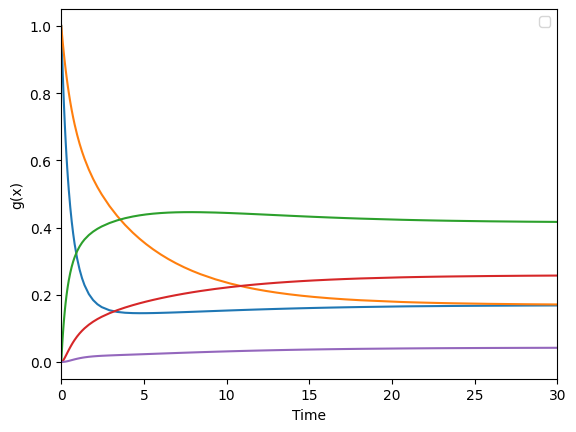

In [114]:
for gx in out_bounded['g']:
    plt.plot(out_bounded['T'], gx)
plt.xlim(0,30)
plt.xlabel('Time')
plt.ylabel('g(x)')
plt.legend()

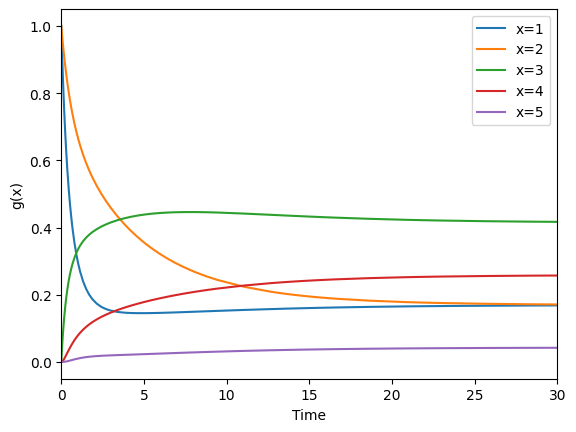

In [203]:
out = solve_ivp(group_formation_model_non_dim, [0, 1000], y0 = g0,
                   method = "LSODA", args = (N1, N2, params)
                  )
g = out.y
i = 1
for gx in g:
    plt.plot(out.t, gx, label = "x=%d"%i)
    i += 1
plt.xlim(0,30)
plt.xlabel('Time')
plt.ylabel('g(x)')
plt.legend()

# Finding equilibria

Can use `numpy.roots(p)` where p are the coefficients



## Functions

In [5]:
def fun_M_no_g1(y, N1, N2, params):
    '''
    Finds the multiplication factor for finding g(x) at equilibrium, but without g(1).
    Works for both scalars and np.array.
    '''
    is_scalar = np.isscalar(y)  # Check if y is a scalar
    y = np.atleast_1d(y)  # Ensure y is an array for uniform processing

    d = params['d']

    pi_of_y = yield_from_prey_non_dim(y, N1, N2, **params)
    pi_of_1 = yield_from_prey_non_dim(1, N1, N2, **params)

    to_return = (1 / y) * ((pi_of_y) / (y * pi_of_1))**d

    # Adjust values for specific y conditions
    to_return = np.where(y == 1, 1, to_return)
    to_return = np.where(y == 2, to_return / 2, to_return)

    return to_return.item() if is_scalar else to_return  # Convert back to scalar if needed

def get_g1_equilibrium(p,N1,N2, params):
    x_max = params['x_max']
    xvec = np.arange(1,x_max+1,1)
    M_vec = fun_M_no_g1(xvec,N1,N2,params)
    coefficients = [i*np.prod(M_vec[0:i]) for i in xvec] # these are actually just the coefficients of g(1), 
    # and they're in reverse order
    reversed_coeff = coefficients[::-1]
    coeff_full = [*reversed_coeff, -p]
    roots = np.roots(coeff_full)
    real_positive_roots = roots[np.isreal(roots) & (roots > 0)].real
    return real_positive_roots

def get_g_equilibria(p,N1,N2,params):
    '''
    Finds all the g(x) equilibria for a certain p,N1,N2 combination
    Assumes population sizes constant

    Returns:
    gvecs, a list of [g(1), g(2), ..., g(xmax)]
    '''
    gvecs = []
    
    g1_roots = get_g1_equilibrium(p,N1,N2, params)
    x_max = params['x_max']
    xvec = np.arange(1,x_max+1,1)
    M_vec = fun_M_no_g1(xvec,N1,N2,params)

    gvecs = [[np.prod(M_vec[0:i])*g1**i for i in xvec] for g1 in g1_roots]
    return gvecs

def classify_equilibrium_g(g, N1, N2, params):
    '''
    Compute the eigenvalues of the Jacobian matrix for just the dynamics of dg(x)/dt
    returns "Stable (attractive)", "Unstable", "Marginally stable (needs further analysis)",
    or "Indeterminate stability (needs further analysis)"
    '''
    J = fun_Jac_groups_nopop(N1, N2, g, **params)
    stability = classify_stability(J)
    return stability

    

def bifurcation_g_input(p, N1, N2, paramkey, paramvec, params_base):
    # initiate empty lists to store params, equilibrium g vecs, and their corresponding stability
    param_vec_to_plot = []
    results_g = []
    stability_results = []
    # iterate over paramvec
    for param in paramvec:
        params = update_params(paramkey, param, params_base)
        # find equilibria. 
        
        g_equilibria = get_g_equilibria(p,N1,N2,params)
        
        for gvec in g_equilibria:
            
            # get stability
            Jac = fun_Jac_groups(N1, N2, gvec, params)
            stability = classify_stability(Jac)
            
            # store
            param_vec_to_plot.append(param)
            results_g.append(gvec)
            stability_results.append(stability)

    # turn outputs into numpy arrays
    results_g = np.array(results_g)
    param_vec_to_plot = np.array(param_vec_to_plot)
    stability_results = np.array(stability_results)

    

    return dict(results_g = results_g, param_vec_to_plot = param_vec_to_plot, 
                stability_results = stability_results)
    




    
def plot_scatter_g(paramkey, xmax, param_vec_to_plot, results_g, stability_results):
    # set up figure
    fig, ax = plt.subplots(1,1)


    # Flatten data for scatter plotting
    param_flat = np.repeat(param_vec_to_plot, results_g.shape[1])  # Repeat params for each group size
    g_flat = results_g.flatten()  # Flatten g values
    stability_flat = np.repeat(stability_results, results_g.shape[1])
    group_sizes = np.tile(np.arange(1, results_g.shape[1] + 1), len(paramvec))  # Repeat group sizes

    # marker set up
    color_map = {x: colors[i] for i, x in enumerate(range(1, xmax+1))}  # Map group size to color
    stable_markers = dict(label = "Stable ", marker = "o", s = 5)
    unstable_markers = dict(label = "Unstable ", marker = 'D', 
                            s = 30, facecolors='none')
    marker_map = {
        "Stable (attractive)": stable_markers,    # Filled circle
        "Unstable": unstable_markers   # Open diamond
    }
    



    # Plot points grouped by stability
    for stability, marker_props in marker_map.items():
        mask = (stability_flat == stability)  # Filter indices for this stability type
        ax.scatter(param_flat[mask], g_flat[mask], 
                   c='none' if stability == "Unstable" else [color_map[x] for x in group_sizes[mask]],  
                   edgecolors=[color_map[x] for x in group_sizes[mask]],  
                   **marker_props)

    format_ax(ax = ax, xlab = param_lab_dic[paramkey], ylab = gxlab, if_legend = False)

        # Legend setup
    legend_handles = []

    # Stability legend
    for stability, marker_props in marker_map.items():
        legend_handles.append(
            plt.Line2D([0], [0], marker=marker_props["marker"], markersize=7, 
                       linestyle = 'None',
                       color='k' if stability == "Unstable" else 'w', 
                       markerfacecolor='k' if stability == "Stable (attractive)" else 'none', 
                       markeredgecolor='k', label=stability)
        )

    # Group size legend
    for x, color in color_map.items():
        legend_handles.append(
            plt.Line2D([0], [0], marker='o', markersize=7, color='w', 
                       markerfacecolor=color, label=f"Group size {x}")
        )

    # Add legend to plot
    ax.legend(handles=legend_handles, title="Legend", loc="best")
        


def get_x_maximizes_pc_fitness(N1, N2, params):
    xvec = np.arange(1,params['x_max']+1,1)
    W_of_x = per_capita_fitness_from_prey_non_dim(xvec, N1, N2, **params)
    max_index = np.argmax(W_of_x)
    return max_index + 1

def plot_actual_vs_optimal_just_g(p, N1, N2, paramkey, paramvec, params_base, bifurcation_dic):
    '''
    plots the mean experienced group size, the equilibrium group size predicted by Mangel and Clark, 
    and the group size that maximizes per capita fitness

    Arguments:
        paramkey (string): label of parameter on the x axis
        paramvec (array): parameter values shown
        params_base (dictionary): dictionary of other parameters
        bifurcation_dic (dictionary): output from `bifurcation_g_input`

    Output:
        fig, ax
    '''
    # set up figure
    fig, ax = plt.subplots(1,1)

    # iterate over paramvec and get the optimal and mangel + clark group sizes
    x_list_mangel_clark = []
    x_list_optimal = []
    for param in paramvec:
        params = update_params(paramkey, param, params_base)
        x_mc = find_mangel_clark(N1, N2, **params)
        x_list_mangel_clark.append(x_mc)
        x_opt = get_x_maximizes_pc_fitness(N1, N2, params)
        x_list_optimal.append(x_opt)

        # get optimal

    # plot optimal and mangel + clark group sizes
    plt.plot(paramvec, x_list_optimal, color = "cyan", lw = 5, label = r'$x$ maximizing $\frac{1}{x} \pi(x)$')

    plt.plot(paramvec, x_list_mangel_clark, color = "blue", label = "Mangel + clark x*")
    
    # calculate mean experienced group size from the results_g element in bifurcation_dic. 
    axis = 1
    x = np.arange(1, params['x_max']+1,1)
    group_densities = bifurcation_dic['results_g']
    prob_experience_x = x*group_densities/p
    
    # Compute E[X] (mean experienced group size)
    mean_exp_x = np.sum(x * prob_experience_x, axis = axis)

    # most frequent group size
    most_freq_x = np.argmax(prob_experience_x,axis = 1)+1

    plt.plot(bifurcation_dic['param_vec_to_plot'], mean_exp_x, color = 'k', label = "Mean Experienced x")
    plt.plot(bifurcation_dic['param_vec_to_plot'], most_freq_x, color = 'magenta', label = "Most Freq. x")
    
    format_ax(ax = ax, xlab=param_lab_dic[paramkey], ylab = r'Group size, $x$', if_legend = True)
    return fig, ax

def plot_line_g(paramkey, x_max, param_vec_to_plot, results_g, stability_results):
    """
    Plots equilibrium g(x) vs. parameter values with:
    - Solid lines for stable points.
    - Dashed lines for unstable points.
    - Colors indicating different group sizes.

    Args:
        param_vec (array-like): Vector of parameter values.
        results_g (2D array): Matrix of g(x) values (rows = params, cols = group sizes).
        stability_results (1D array): array of stability labels ("Stable (attractive)" or "Unstable").

    Returns: 
        tuple (pointers to fig, ax)
    """
    fig, ax = plt.subplots(1,1)
    group_sizes = np.arange(1,x_max+1,1)

    
    for i, x in enumerate(group_sizes):
        # get stuff to plot
        gx = results_g[:,i]
        
        # Separate stable and unstable points
        stable_mask = (stability_results == "Stable (attractive)")
        unstable_mask = (stability_results == "Unstable")
        
        # Plot stable values (solid line)
        ax.plot(param_vec_to_plot[stable_mask], gx[stable_mask], 
                color=colors[i], linestyle='-', label = "x=%d"%x)
    
        # plot unstable values (dahsed line)
        ax.plot(param_vec_to_plot[unstable_mask], gx[unstable_mask], 
                color=colors[i], linestyle='--')
        
        #ax.plot(out_dict['param_vec_to_plot'], gx, color = colors[i], label = "x=%d"%x)
    
    format_ax(ax = ax, xlab = param_lab_dic[paramkey], ylab = gxlab, if_legend = True)
    return fig, ax

In [6]:
from local_stability_funs import fun_Jac_groups_helper
def fun_Jac_groups(N1, N2, gvec, params):
    '''
    Finds the Jacobian if N1, N2, p are constant
    '''
    x_max = params['x_max']
    xvec = np.arange(1,x_max+1,1)

    # the gradients of the functional responses relative to big prey and small prey
    grad_f1 = np.zeros((2,x_max))
    grad_f2 = np.zeros((2,x_max))


    # the jacobian has two columns that need to be eliminated because they corrrespond to the gradient of dg/dt wrt N1, N2
    Jac_need_to_trim = fun_Jac_groups_helper(N1, N2, gvec, grad_f1, grad_f2, xvec, **params)

    Jac = Jac_need_to_trim[:, 2:]
    return Jac

# bifurcation, just g, relative to scale

In [7]:
params_base = {'η1': 0.2,
 'η2': 0.5,
 'A': 0.5,
 'β1': 4,
 'β2': 1,
 'H1': 4,
 'H2': 1,
 'α1_of_1': 0.05,
 'α2_of_1': 0.95,
 's1': 2,
 's2': 2,
 'α2_fun_type': 'constant',
 'x_max': 5,
 'd': 10,
 'Tx': 1,
 'pop_process': False}


p = 3
N1 = 1
N2 = 1

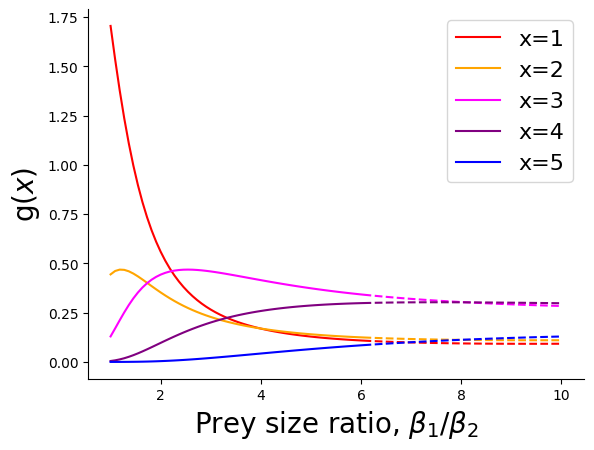

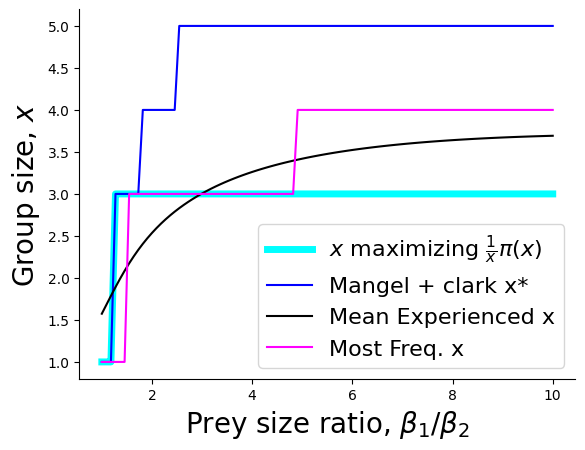

In [8]:
paramkey = 'scale'
paramvec = np.linspace(1,10,100)
p = 3
N1 = 1
N2 = .5
#plot_scatter_g(paramkey, 5, **out_dict)
out_dict = bifurcation_g_input(p, N1, N2, paramkey, paramvec, params_base)
fig, ax = plot_line_g(paramkey = paramkey, x_max = 5, **out_dict)
fig_optimal, ax_optimal = plot_actual_vs_optimal_just_g(p, N1, N2, paramkey, paramvec, params_base, bifurcation_dic = out_dict)

In [278]:
final_fig_path

'../CH_Manuscript/Figures/'

In [8]:
fig.savefig(final_fig_path + 'equilibria_only_groups_vs_scale.eps', **figure_ops)
fig_optimal.savefig(final_fig_path + 'optimal_comparison_only_groups_vs_scale.eps', **figure_ops)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Can you use separation of time scales to find g at each (normal) time point?

In [42]:
params_base = {'η1': 0.2,
 'η2': 0.5,
 'A': 0.7,
 'β1': 4,
 'β2': 1,
 'H1': 4,
 'H2': 1,
 'α1_of_1': 0.05,
 'α2_of_1': 0.95,
 's1': 2,
 's2': 2,
 'α2_fun_type': 'constant',
 'x_max': 5,
 'd': 10,
 'Tx': .001,
 'pop_process': True}

In [43]:
from group_w_pop_funs import bounded_ivp
y0 = [1,1,*get_g_equilibria(p=3, N1=1, N2=1, params = params_base.copy())[0]]
out = bounded_ivp(y0,params_base.copy(), t_f = 1000, if_dict = True)

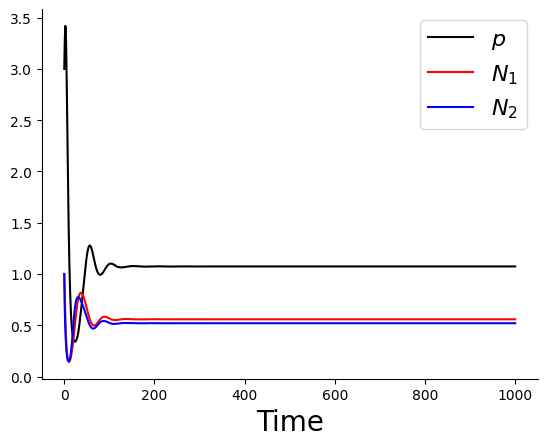

In [44]:
plt.plot(out['T'],out['p'],'k', label = '$p$')
plt.plot(out['T'],out['N1'],'r', label = r'$N_1$')
plt.plot(out['T'],out['N2'],'b', label = r'$N_2$')
format_ax(ax = plt.gca(), xlab = 'Time', ylab = "", if_legend=True)

In [45]:
out_g = [get_g_equilibria(p, N1, N2, params_base.copy())[0] for p,N1,N2 in zip(out['p'],out['N1'],out['N1'])]
g_time_separate = np.array(out_g)

In [46]:
axis = 1
x = np.arange(1, params_base['x_max']+1,1)
#group_densities = g_time_separate
prob_experience_x = x*g_time_separate/out['p'][:,np.newaxis]

# Compute E[X] (mean experienced group size)
mean_exp_x = np.sum(x * prob_experience_x, axis = axis)

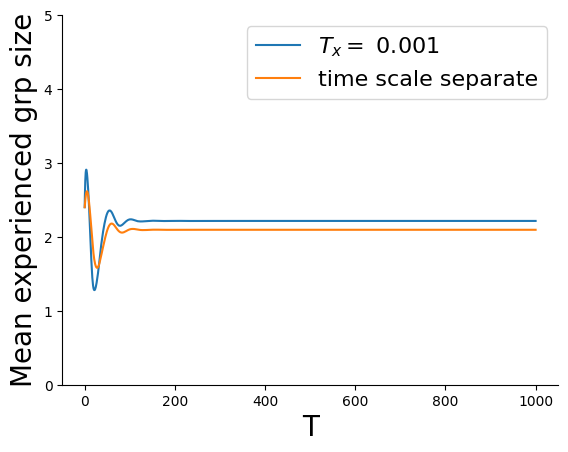

In [49]:
plt.plot(out['T'],out['mean_x'], label = r'$T_x =$' + ' %.3f'%params_base['Tx'])
plt.plot(out['T'],mean_exp_x, label = "time scale separate")
plt.ylim(0,5)
format_ax(ax = plt.gca(),xlab = 'T', ylab = "Mean experienced grp size", if_legend = True)

In [50]:
mean_exp_x[-1]

np.float64(2.0959901620561436)

In [51]:
out['mean_x'][-1]

np.float64(2.2158053469439385)